In [2]:
import pandas as pd
from BinanceAPI import getCandles
from datetime import datetime
import ta
import json

<AxesSubplot:>

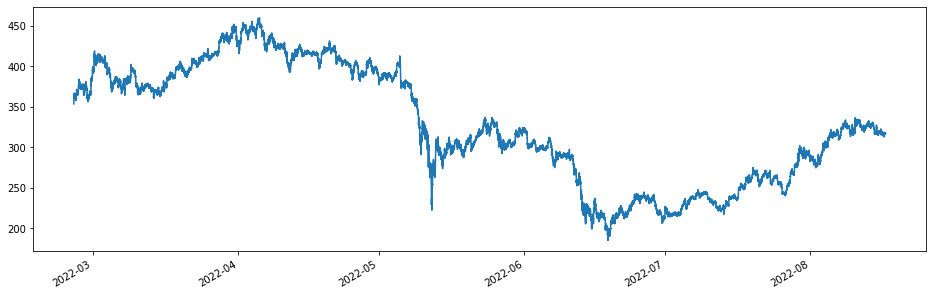

In [8]:
candles = json.loads(open("./dataset5M.json").read())
dates = [datetime.fromtimestamp(c[0]/1000) for c in candles]
df = pd.DataFrame([c[1:] for c in candles[:-1]], index=dates[:-1], columns=["open", "high", "low", "close", "volume"])
im_indicator = ta.trend.IchimokuIndicator(high=df["high"], low=df["low"], window1=9, window2=26, window3=52)
df["rsi"] = ta.momentum.RSIIndicator(df["close"], window=7).rsi()
df["spanA"] = im_indicator.ichimoku_a()
df["spanB"] = im_indicator.ichimoku_b()
df["kijun"] = im_indicator.ichimoku_base_line()
df["tenkan"] = im_indicator.ichimoku_conversion_line()
df["EMA50"] = ta.trend.EMAIndicator(close=df["close"], window=50).ema_indicator()
df["EMA100"] = ta.trend.EMAIndicator(close=df["close"], window=100).ema_indicator()
df["EMA150"] = ta.trend.EMAIndicator(close=df["close"], window=150).ema_indicator()
df = df.dropna()
df["close"].plot(figsize=(16, 5))
#pd.concat([df, pd.DataFrame([candles[-1][1:]], index=[datetime.fromtimestamp(candles[-1][0]/1000)], columns=["open", "high", "low", "close", "volume"])])

In [17]:
trendUp = pd.DataFrame([1 if df["EMA50"][i] > df["EMA100"][i] > df["EMA150"][i]
                        else 0 for i in range(len(df["close"]))])
ichimokuUp = pd.DataFrame([1 if df["spanA"][i] < df["spanB"][i] 
                        and df["tenkan"][i] < df["kijun"][i]
                        else 0 for i in range(len(df["close"]))])

In [13]:
buy = False
winRate = []
wallet = [1000]
saveWallet = [0]
waitB = False
for i in range(len(trendUp)):
    #if i % 10080 == 0:
    #    saveWallet.append(saveWallet[-1] + (wallet[-1] * 0.01))
    #    wallet.append(wallet[-1] - (wallet[-1] * 0.01))
    #if waitB and i % 1440 == 0:
    #    waitB = False
    if ichimokuUp[0][i] == 1 and not buy:
        buy = df["close"][i]
        #waitB = True
    elif buy and df["close"][i] <= (buy - (buy * 0.008)):
        winRate.append(0)
        wallet.append(wallet[-1] + (wallet[-1] * -((buy - df["close"][i])/buy) * 1))
        buy = False
    elif buy and df["close"][i] >= (buy + (buy * 0.01)):
        winRate.append(1)
        wallet.append(wallet[-1] + (wallet[-1] * ((df["close"][i] - buy)/buy) * 1))
        buy = False
str(round((sum(winRate) / len(winRate)) * 100, 2))+"%"

'46.79%'

<AxesSubplot:>

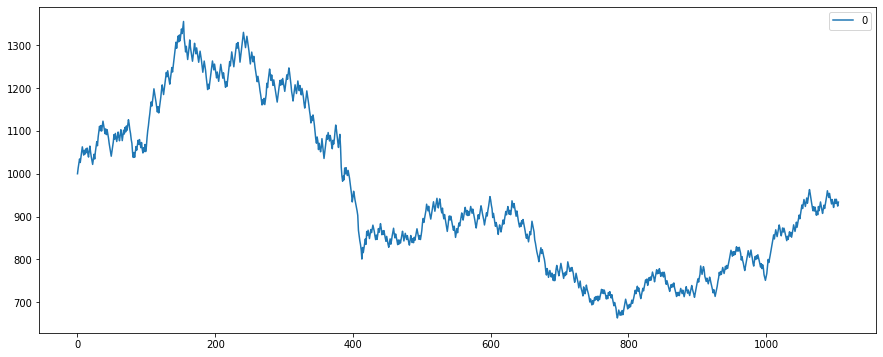

In [14]:
pd.DataFrame(wallet).plot(figsize=(15,6))